# Gaussian Sampling and use of Maximal Likliehood Estimators

In [1]:
import numpy as np
import scipy.stats as stats
import scipy.optimize as optimize
%matplotlib inline
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider
import ipywidgets as widgets

Let's sample $n$ measurements from a Gaussian distribution with true mean $\mu$ and true standard deviation $\sigma$ that are unknown to us.

In [2]:
x = np.linspace(-5.0, 5.0, num=10000)
# mean and standard deviation
mu = np.random.uniform(-0.5,0.5)
sigma = np.random.uniform(0.1,1.0)

# sample the distribution
number_of_samples = 50
samples = np.random.normal(mu, sigma, number_of_samples)
samples.sort()

First let's determine the sample parameters: the sample mean and the sample standard deviation.

In [3]:
# get sample parameters
sample_mean = np.mean(samples)
sample_std = np.std(samples)
print('The mean of the samples is {:.5f}'.format(sample_mean))
print('The standard deviation of the samples is {:.5f}'.format(sample_std))

The mean of the samples is 0.37637
The standard deviation of the samples is 0.73867


From lecture, it is known that the maximal likeilhood estimators of a Gaussian distribution are

$\displaystyle \hat{\mu} = \frac{1}{n} \sum_{i=1}^{n} x_i \equiv \bar{x}$,

and

$\displaystyle \hat{\sigma} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} \left(x_i - \hat{\mu}\right)^2} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} \left(x_i - \bar{x}\,\right)^2}$.

[NumPy](http://www.numpy.org/)'s methods for [$\texttt{mean}$](http://docs.scipy.org/doc/numpy/reference/generated/numpy.mean.html) and [$\texttt{std}$](http://docs.scipy.org/doc/numpy/reference/generated/numpy.std.html) will return these, but let's explicility check:

In [4]:
def mle_mean(data):
    sum = 0
    for x in data:
        sum += x
    n = len(data)
    return sum/n


def mle_std(data):
    sum = 0
    for x in data:
        sum += (x - mle_mean(data)) ** 2
    n = len(data)
    return np.sqrt(sum/n)


epsilon = 10 ** (-15)
if np.absolute(mle_mean(samples) - sample_mean) < epsilon:
    print('Sample mean is the MLE mean.')
else:
    print('Sample mean is NOT the MLE mean.')
    
if np.absolute(mle_std(samples) - sample_std) < epsilon:
    print('Sample std is the MLE std.')
else:
    print('Sample std is NOT the MLE std.')

Sample mean is the MLE mean.
Sample std is the MLE std.


Now that we are confident our estimates of the true distribution mean and standard deviation are the best we can make with our samples let's create a probability distribution function from the sample parameters,

In [5]:
sample_distribution = stats.norm.pdf(x, sample_mean, sample_std)
true_distribution = stats.norm.pdf(x, mu, sigma)

and now let's visuzlaize our data by plotting the sampled measurments with the sample (MLE) distribution.

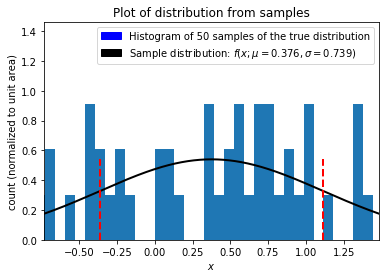

In [6]:
n_bins = 1
if number_of_samples < 50:
    n_bins = number_of_samples
else:
    n_bins = 50

# Plots
plt.figure(1)

# Plot histogram of samples
hist_count, bins, _ = plt.hist(samples, n_bins, normed=True) #Norm to keep distribution in view
# Plot distribution using sample parameters
plt.plot(x, sample_distribution, linewidth=2, color='black')
# draw standard deviation in dashed lines
plt.plot((sample_mean + sample_std, sample_mean + sample_std), (0, sample_distribution.max()), linestyle='dashed',
         linewidth=2, color='red')
plt.plot((sample_mean - sample_std, sample_mean - sample_std), (0, sample_distribution.max()), linestyle='dashed',
         linewidth=2, color='red')

# Axes
plt.title('Plot of distribution from samples')
plt.xlabel('$x$')
plt.ylabel('count (normalized to unit area)')
sample_window_w = sample_std * 1.5
plt.xlim([sample_mean - sample_window_w, sample_mean + sample_window_w])
plt.ylim([0, hist_count.max() * 1.6])

# Legends
sample_patch = mpatches.Patch(color='black',
                              label='Sample distribution: $f(x;\mu={:.3f},\sigma={:.3f})$'.format(sample_mean,
                                                                                                  sample_std))
data_patch = mpatches.Patch(color='blue',
                            label='Histogram of {} samples of the true distribution'.format(number_of_samples))

plt.legend(handles=[data_patch, sample_patch])

plt.show()

Now that we have the sample distribution, let's comapre it to the true distribution and see how they well they agree.

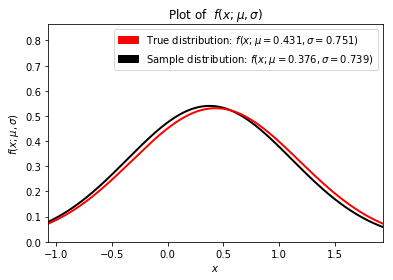

In [7]:
plt.figure(2)

# Plot distribution using sample parameters
plt.plot(x, sample_distribution, linewidth=2, color='black')
plt.plot(x, true_distribution, linewidth=2, color='red')  # Plot true distribution

# Axes
plt.title('Plot of  $f(x;\mu,\sigma)$')
plt.xlabel(r'$x$')
plt.ylabel(r'$f(x;\mu,\sigma)$')
dist_window_w = sigma * 2
plt.xlim([mu - dist_window_w, mu + dist_window_w])
if sample_distribution.max() > true_distribution.max():
    plt.ylim([0, sample_distribution.max() * 1.6])
else:
    plt.ylim([0, true_distribution.max() * 1.6])

# Legends
true_patch = mpatches.Patch(
    color='red', label='True distribution: $f(x;\mu={:.3f},\sigma={:.3f})$'.format(mu, sigma))

plt.legend(handles=[true_patch, sample_patch])

plt.show()

To get a feel for how sample size affects the quality of the estimate vary the sample size (e.g., 5, 10, 100, 1000) and run the notebook multiple times for each sample size.

## Numerical MLE techniques

We arrived at the sample distribution parameters by finding the maximal estimators $\hat{\mu}$ and $\hat{\sigma}$ analytically as the distribution is Gaussian. Alternatively, we could have (as you must in most cases) found them numerically by minimizing $-\ln L(\vec{x}; \hat{\vec{\theta}})$, which is

$\displaystyle -\ln L\left(\vec{x}; \hat{\mu}, \hat{\sigma}\right) = \frac{n}{2} \ln\left(2 \pi\right) + n \ln \hat{\sigma} + \frac{1}{2 \hat{\sigma}^2} \sum_{i=1}^{n} \left(x_i - \hat{\mu}\right)^2$

In [8]:
def negative_log_L(data, mean_estimate, std_estimate):
    sum = 0
    for x in data:
        sum += (x - mean_estimate) ** 2
    n = len(data)
    return (n * np.log(2 * np.pi)/2) + (n * np.log(std_estimate)) + (sum / (2 * (std_estimate ** 2)))

Let's use [Brent's method](http://www.scipy-lectures.org/advanced/mathematical_optimization/#getting-started-1d-optimization) for a scalar function to minimize the likelihood estimate and then visualize it.

In [9]:
def min_L_mean(x):
    return negative_log_L(samples, x, sample_std)

def min_L_std(x):
    return negative_log_L(samples, sample_mean, x)

min_mean = optimize.brent(min_L_mean)
min_std = optimize.brent(min_L_std)

/home/mcf/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in log
/home/mcf/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in double_scalars
/home/mcf/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in double_scalars


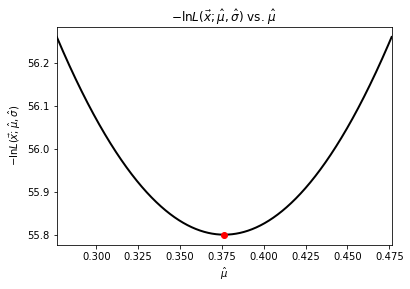

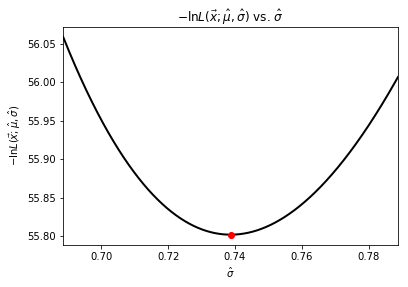

In [10]:
# Negative Log Likelihood curves
plt.figure(3)
theta = np.linspace(sample_mean - 0.1, sample_mean + 0.1, num=10000)
plt.plot(theta, negative_log_L(samples, theta, sample_std),
         linewidth=2, color='black')
plt.plot([min_mean], [min_L_mean(min_mean)], 'ro')


plt.title(r'$-\ln L(\vec{x};\hat{\mu}, \hat{\sigma})$ vs. $\hat{\mu}$')
plt.xlabel(r'$\hat{\mu}$')
plt.ylabel(r'$-\ln L(\vec{x};\hat{\mu}, \hat{\sigma})$')
plt.xlim([sample_mean - 0.1, sample_mean + 0.1])

plt.figure(4)
phi = np.linspace(sample_std - 0.05, sample_std + 0.05, num=10000)
plt.plot(phi, negative_log_L(samples, sample_mean, phi),
         linewidth=2, color='black')
plt.plot([min_std], [min_L_std(min_std)], 'ro')

plt.title(r'$-\ln L(\vec{x};\hat{\mu}, \hat{\sigma})$ vs. $\hat{\sigma}$')
plt.xlabel(r'$\hat{\sigma}$')
plt.ylabel(r'$-\ln L(\vec{x};\hat{\mu}, \hat{\sigma})$')
plt.xlim([sample_std - 0.05, sample_std + 0.05])

plt.show()

In [11]:
def plot_L_mean(x):
    a = 2*sample_mean - x
    b = x
    delta = 0.15
    ymin = min_L_mean(sample_mean) * .998
    plt.xlim([sample_mean - delta, sample_mean + delta])
    plt.ylim([ymin, min_L_mean(sample_mean + delta)])
    theta = np.linspace(sample_mean - delta, sample_mean + delta, num=1000)
    plt.plot(theta, negative_log_L(samples, theta, sample_std), linewidth=2, color='black')
    plt.plot([min_mean], [min_L_mean(min_mean)], 'ro')
    plt.plot((a, a), (ymin, min_L_mean(a)), linestyle='dashed',linewidth=2, color='black')
    plt.plot((b, b), (ymin, min_L_mean(b)), linestyle='dashed',linewidth=2, color='black')
    plt.axhline(min_L_mean(b), linestyle='dashed',linewidth=2, color='black')
    plt.plot([a, b], [min_L_mean(a), min_L_mean(b)], 'wo')
    plt.title(r'$-\ln L(\vec{x};\hat{\mu}, \hat{\sigma})$ vs. $\hat{\mu}$')
    plt.xlabel(r'$\hat{\mu}$')
    plt.ylabel(r'$-\ln L(\vec{x};\hat{\mu}, \hat{\sigma})$')
    plt.show()
    print('2 Delta L: {}'.format(2*(min_L_mean(x) - min_L_mean(min_mean))))
    
def plot_L_std(x):
    a = 2*sample_std - x
    b = x
    delta = 0.15
    ymin = min_L_std(sample_std) * .998
    plt.xlim([sample_std - delta, sample_std + delta])
    plt.ylim([ymin, min_L_std(sample_std + delta)])
    theta = np.linspace(sample_std - delta, sample_std + delta, num=1000)
    plt.plot(theta, negative_log_L(samples, sample_mean, theta), linewidth=2, color='black')
    plt.plot([min_std], [min_L_std(min_std)], 'ro')
    plt.plot((a, a), (ymin, min_L_std(a)), linestyle='dashed',linewidth=2, color='black')
    plt.plot((b, b), (ymin, min_L_std(b)), linestyle='dashed',linewidth=2, color='black')
    plt.axhline(min_L_std(b), linestyle='dashed',linewidth=2, color='black')
    plt.plot([a, b], [min_L_std(a), min_L_std(b)], 'wo')
    plt.title(r'$-\ln L(\vec{x};\hat{\mu}, \hat{\sigma})$ vs. $\hat{\sigma}$')
    plt.xlabel(r'$\hat{\sigma}$')
    plt.ylabel(r'$-\ln L(\vec{x};\hat{\mu}, \hat{\sigma})$')
    plt.show()
    print('2 Delta L:{}'.format(2*(min_L_std(x) - min_L_std(min_std))))

To be able to quantify our estimates we can place uncertainties on them using our log-likelihood functions. As the log likelihood-ratio test shows us that

$\displaystyle -2\ln\Lambda\left(\hat{\theta}\right) = 2 \Delta \left(-\ln L\right) = 2\, \ln\left(\frac{-L\left(\vec{x}; \hat{\vec{\theta}}\right)}{-L\left(\vec{x}; \hat{\vec{\theta}_0}\right)}\right) = 2 \left(-\ln L\left(\vec{x}; \hat{\vec{\theta}}\right) + \ln L\left(\vec{x}; \hat{\vec{\theta}_0}\right)\right)= s^2$,

is approximatley distributed as $\chi^2$ when the sample size $n$ is large, then to find the $s\sigma$ confidence level on our estimates we just vary our estimate $\hat{\theta}$ until $\displaystyle -2\ln\Lambda\left(\hat{\theta}\right) = s^2$. Use the sliders below to vary $\hat{\mu}$ and $\hat{\sigma}$ to find the $1\sigma$ uncertainities (~68% confidence levels).

In [12]:
interact(plot_L_mean, x=widgets.FloatSlider(min=sample_mean, max=sample_mean + 0.15,
                                            step=0.001, value=sample_mean))

Widget Javascript not detected.  It may not be installed or enabled properly.


<function __main__.plot_L_mean>

In [13]:
interact(plot_L_std, x=widgets.FloatSlider(min=sample_std, max=sample_std + 0.15,
                                            step=0.001, value=sample_std))

Widget Javascript not detected.  It may not be installed or enabled properly.


<function __main__.plot_L_std>

In [14]:
def negative_two_log_Lambda(data, x, y, a, b):
    return 2 * (negative_log_L(data, x, y) - negative_log_L(data, a, b))

In [15]:
def plot_Lambda_mean():
    width = 0.2
    plt.xlim([sample_mean - width, sample_mean + width])
    theta = np.linspace(sample_mean - width, sample_mean + width, num=10000)
    plt.plot(theta, negative_two_log_Lambda(samples, theta, sample_std, min_mean, min_std),
         linewidth=2, color='black')
    plt.plot([sample_mean], [negative_two_log_Lambda(samples, sample_mean, sample_std, min_mean, min_std)], 'ro')
    plt.axhline(1, linestyle='dashed',linewidth=1, color='black')
    plt.title(r'$-2\ln \,\Lambda(\hat{\mu})$ vs. $\hat{\mu}$')
    plt.xlabel(r'$\hat{\mu}$')
    plt.ylabel(r'$-2\ln \,\Lambda(\hat{\mu})$')
    plt.show()
    
def plot_Lambda_std():
    width = 0.15
    plt.xlim([sample_std - width, sample_std + width])
    theta = np.linspace(sample_std - width, sample_std + width, num=10000)
    plt.plot(theta, negative_two_log_Lambda(samples, sample_mean, theta, min_mean, min_std),
         linewidth=2, color='black')
    plt.plot([sample_std], [negative_two_log_Lambda(samples, sample_mean, sample_std, min_mean, min_std)], 'ro')
    plt.axhline(1, linestyle='dashed',linewidth=1, color='black')
    plt.title(r'$-2\ln \,\Lambda(\hat{\sigma})$ vs. $\hat{\sigma}$')
    plt.xlabel(r'$\hat{\sigma}$')
    plt.ylabel(r'$-2\ln \,\Lambda(\hat{\sigma})$')
    plt.show()

We can also visualize this by plotting $-2\ln\Lambda\left(\hat{\theta}\right)$ vs $\hat{\theta}$:

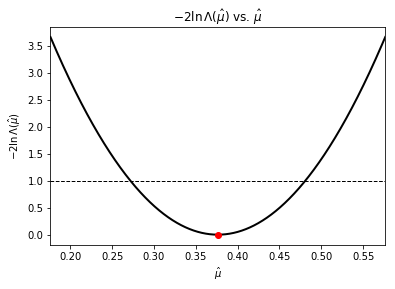

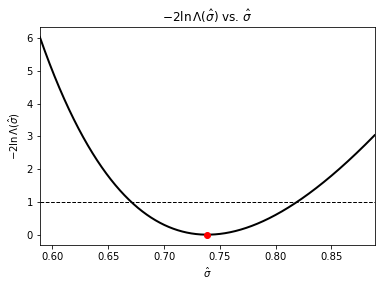

In [16]:
plot_Lambda_mean()
plot_Lambda_std()